# Marine Heatwaves Definition

In [ ]:
# Goal of this script: 
# produce a mhws detection by (lat, lon) "chunks" of HadSST daily. Lat is set to one for now for ease of dimensionality 
#
# start with a single decade for now (also tested for 18 years)
#
# Next steps: 
# - add block post-processing
# - add recombining regions
# - if needed, add other thresholds for characterization

In [ ]:
#         'time_start'           Start time of MHW [datetime format]
#         'time_end'             End time of MHW [datetime format]
#         'time_peak'            Time of MHW peak [datetime format]
#         'date_start'           Start date of MHW [datetime format]
#         'date_end'             End date of MHW [datetime format]
#         'date_peak'            Date of MHW peak [datetime format]
#         'index_start'          Start index of MHW
#         'index_end'            End index of MHW
#         'index_peak'           Index of MHW peak
#         'duration'             Duration of MHW [days]
#         'intensity_max'        Maximum (peak) intensity [deg. C]
#         'intensity_mean'       Mean intensity [deg. C]
#         'intensity_var'        Intensity variability [deg. C]
#         'intensity_cumulative' Cumulative intensity [deg. C x days]
#         'rate_onset'           Onset rate of MHW [deg. C / days]
#         'rate_decline'         Decline rate of MHW [deg. C / days]

In [1]:
# Load required modules
import numpy as np
from datetime import date
from matplotlib import pyplot as plt
from scipy.ndimage import label
import pandas as pd
import xarray
import glob
%matplotlib inline
import time

In [ ]:
## Add: dictionary with path for day/5day/mon data, raw/clim/anom/th90 

In [15]:
dtype = 'anom'
dfreq = 'day'
finstr = f'/lcrc/group/e3sm/public_html/diagnostics/observations/Ocean/SST/daily/sst.{dfreq}.{dtype}'
finstr = f'/lcrc/group/e3sm/ac.abarthel/scratch/mhw/hadSST/daily/sst.{dfreq}.{dtype}'

In [12]:
timeperiod = [1982, 2023]
def generate_fileList(timeperiod, filestring, dtype):
    if dtype == 'mean':
        filelist = [f'{finstr}.{year}.nc' for year in np.arange(timeperiod[0], timeperiod[1]+1)]
    if dtype == 'anom':
        filelist = [f'{finstr}.{year}.clim1982-2023.nc' for year in np.arange(timeperiod[0], timeperiod[1]+1)]
    return filelist

In [16]:
infiles = generate_fileList(timeperiod, finstr, dtype)
nyears = len(infiles)

In [332]:
totalyears = np.arange(timeperiod[0],timeperiod[1]+1)

## Load the HadSST daily temperature time series

In [ ]:
# essential for mhw detection (at this stage):
# - anom
# - th90 

In [ ]:
next step: redo ilat sweep for blocklon = 22

In [19]:
# load anomalies for the needed years
ds = xarray.open_mfdataset(infiles)

/lcrc/soft/climate/e3sm-unified/base/envs/e3sm_unified_1.10.0_login/lib/python3.10/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


In [334]:
dlon =10
blocklon = np.arange(0, 360, dlon)
ilat = 520
iiblocklon = 23

In [348]:
ds.lat[600]

<xarray.DataArray 'lat' ()>
array(60.125, dtype=float32)
Coordinates:
    lat      float32 60.12
Attributes:
    long_name:      Latitude
    standard_name:  latitude
    units:          degrees_north
    actual_range:   [-89.875  89.875]
    axis:           Y

In [349]:
for ilat in np.arange(521,600):
    print(ilat)
    # load anomalies for the needed years
    #ds = xarray.open_mfdataset(infiles)
    subds = ds.where((ds.lon >= blocklon[iiblocklon]) & (ds.lon < blocklon[iiblocklon+1])& (ds.lat ==ds.lat[ilat]) , drop=True)
    anom = subds.sst

    # load threshold clim
    fin = f'/lcrc/group/e3sm/ac.abarthel/scratch/mhw/hadSST/daily/sst.day.th90.anom1982-2023.clim1982-2023.nc'
    dsth90 = xarray.open_dataset(fin).threshold90.where((ds.lon >= blocklon[iiblocklon]) & (ds.lon < blocklon[iiblocklon+1])& (ds.lat ==ds.lat[ilat]) , drop=True)
    print('loading the regional chunk of data...')
    start = time.time()
    th90clim = dsth90.values
    end = time.time()
    print(f'... took {end - start}s to load')
    th90 = np.tile(th90clim[:,0, :], (nyears, 1))

    # maybe insert a load() here to split the load vs calc timing
    print('loading the regional chunk of anomaly data...')
    start = time.time()
    ssta = anom[:,0,:].values
    end = time.time()
    print(f'... took {end - start}s to load')

    # maybe add chunk(dict(time=-1)) above to avoid chunking in time? Tested: similar time

    print('detecting events above threshold')
    start = time.time()
    # Potentially ADD smooth percentile here
    mhw_bool = (ssta > th90)
    # Find contiguous regions of exceed_bool = True
    s2 = [[0,1,0],
          [0,1,0],
          [0,1,0]]
    events, n_events = label(mhw_bool, structure = s2)
    end = time.time()
    print(f'... took {end - start}s to calculate mhw events')
    # sanity check regarding shape of event (lon contains all equal values)
    check = all([len(subds.lon[np.where(events == ev)[1]].drop_duplicates(dim = 'lon'))==1 for ev in np.arange(1, n_events+1)] )
    if ~check:
        'problem with the structure of events and/or lon'
    print(f'{n_events} events were detected')
    # probably save intermediate files here like temp, seas, th90 and (events, n_events)



    mhw_info = ['lon', 'lat', 'duration', 
            'date_start',
            'date_end',
            'date_peak',
            'index_start',
            'index_end',
            'index_peak',
            'intensity_max',
            'intensity_mean',
            'intensity_var',
            'intensity_cumulative',
            'rate_onset',
            'rate_decline', 
            'category']
    # Creating Empty DataFrame and Storing it in variable df
    df = pd.DataFrame([], columns = mhw_info, index = np.arange(1, n_events+1))
    df.lat = np.tile(subds.lat.values, n_events) # For now Lat is 1 value from chunk mask. 

    mhw_relSeas = ssta

    minDuration = 5
    df.duration = [(events == ev).sum() for ev in np.arange(1, n_events+1)]
    # drop the short duration events here and save on calculations
    df.drop(df[df.duration < minDuration].index, inplace = True)
    # the rest can be done over subselected events (i.e. df.index)

    # check above confirms we appropriately only have one lon value)
    df.lon = [subds.lon[np.where(events == ev)[1]].drop_duplicates(dim = 'lon').values[0] for ev in df.index]
    #df.loc[:].lat = subds.lat.values # For now Lat is 1 value from chunk mask. 
    df.index_start = [np.where(events == ev)[0][0] for ev in df.index]
    df.index_end = [np.where(events == ev)[0][-1] for ev in df.index]
    df.date_start = [subds.time[np.where(events == ev)[0][0]].values for ev in df.index]
    df.date_end = [subds.time[np.where(events == ev)[0][-1]].values for ev in df.index]
    df.index_peak = [df.loc[ev].index_start + np.argmax(mhw_relSeas[np.where(events == ev)]) for ev in df.index]
    df.date_peak = [subds.time[df.loc[ev].index_peak].values for ev in df.index]
    df.intensity_max = [mhw_relSeas[np.where(events == ev)].max() for ev in df.index]
    df.intensity_mean = [mhw_relSeas[np.where(events == ev)].mean() for ev in df.index]
    df.intensity_var = [np.sqrt(mhw_relSeas[np.where(events == ev)].var()) for ev in df.index]
    df.intensity_cumulative = [mhw_relSeas[np.where(events == ev)].sum() for ev in df.index]
    # add additional indices if needed

    # congrats, you attained your original goal to produce the REGIONAL mhw dataframe using the GLOBAL anom/th90 files produced offline.
    # Save mhw dataframe?

    #output 
    df['event'] = df.index
    dataset = xarray.Dataset.from_dataframe(df)
    dataset = dataset.assign_coords({"lon": (df.lon)})
    dataset = dataset.assign_coords({"lat": (df.lat)})

    fout_mhw = f'/lcrc/group/e3sm/ac.abarthel/scratch/mhw/hadSST/daily/mhw/mhw.1982-2023.clim1982-2023.lonblock{iiblocklon}.{ilat}.nc'
    dataset.to_netcdf(fout_mhw)
    #print(f'saved to {fout_mhw}')


    
    
    print("processing block info")
    # STEP 3 produce the block information using the above dataframe (may not require a new object, only manipulating/copying the above)

    dftemp = df.copy()

    dftemp['year'] = [dftemp.loc[ev].date_start.year for ev in dftemp.index]

    # for each year (of MHW start for now), produce
    # nber of mhw (count)
    # total duration (which is duration.sum)
    # intensity cumulative (which is sum)
    # average intensity (mean of mean - though this should include area averaging if several cells)
    # do it first for one cell
    # then expand to several cells? 



    mhw_stats = ['n_mhw','duration_cum', 'duration_max',
                'intensity_mean', 'intensity_max', 'intensity_cum']

    for singlelon in dftemp.lon.unique():
        ilon = np.where(ds.lon == singlelon)[0][0]
        oneCell = dftemp[dftemp['lon'] == singlelon]
        mhw_yrs = oneCell.year.unique()

        yearlydf = pd.DataFrame([], columns = mhw_stats, index = mhw_yrs)
        yearlydf['n_mhw']=np.array(oneCell.groupby(oneCell.year).duration.count())
        yearlydf['duration_cum']=np.array(oneCell.groupby(oneCell.year).duration.sum())
        yearlydf['duration_max']=np.array(oneCell.groupby(oneCell.year).duration.max())
        yearlydf['intensity_mean']=np.array(oneCell.groupby(oneCell.year).intensity_mean.mean())
        yearlydf['intensity_max']=np.array(oneCell.groupby(oneCell.year).intensity_max.max())
        yearlydf['intensity_cum']=np.array(oneCell.groupby(oneCell.year).intensity_cumulative.sum())

        #new_index = pd.RangeIndex(len(df)*(n+1))
        new_df = pd.DataFrame(index=totalyears, columns=yearlydf.columns, dtype='object')
        ids = np.array(mhw_yrs)
        new_df.loc[ids] = yearlydf.values

        data = xarray.Dataset.from_dataframe(new_df)
        data = data.assign_coords({"lon": ([singlelon])})
        data = data.assign_coords({"lat": ([singlelat])})

        # save data as single dataset with number
        fout = f'/lcrc/group/e3sm/ac.abarthel/scratch/mhw/hadSST/daily/mhw/mhw_stats.1982-2023.clim1982-2023.{ilon}.{ilat}.nc'
        data.to_netcdf(fout)
        #print(f'saved to {fout}')

521
loading the regional chunk of data...
... took 5.245208740234375e-06s to load
loading the regional chunk of anomaly data...
... took 251.30016660690308s to load
detecting events above threshold
... took 0.0034470558166503906s to calculate mhw events
7599 events were detected
processing block info
522
loading the regional chunk of data...
... took 1.0251998901367188e-05s to load
loading the regional chunk of anomaly data...
... took 249.89952516555786s to load
detecting events above threshold
... took 0.0033180713653564453s to calculate mhw events
7642 events were detected
processing block info
523
loading the regional chunk of data...
... took 1.430511474609375e-05s to load
loading the regional chunk of anomaly data...
... took 250.10415387153625s to load
detecting events above threshold
... took 0.003505706787109375s to calculate mhw events
8061 events were detected
processing block info
524
loading the regional chunk of data...
... took 1.1682510375976562e-05s to load
loading the

... took 250.341650724411s to load
detecting events above threshold
... took 0.003247499465942383s to calculate mhw events
7999 events were detected
processing block info
549
loading the regional chunk of data...
... took 1.0013580322265625e-05s to load
loading the regional chunk of anomaly data...
... took 250.084538936615s to load
detecting events above threshold
... took 0.0034961700439453125s to calculate mhw events
7710 events were detected
processing block info
550
loading the regional chunk of data...
... took 1.0251998901367188e-05s to load
loading the regional chunk of anomaly data...
... took 250.4527871608734s to load
detecting events above threshold
... took 0.0032613277435302734s to calculate mhw events
7806 events were detected
processing block info
551
loading the regional chunk of data...
... took 4.5299530029296875e-06s to load
loading the regional chunk of anomaly data...
... took 250.27897810935974s to load
detecting events above threshold
... took 0.0034084320068359

loading the regional chunk of data...
... took 1.5497207641601562e-05s to load
loading the regional chunk of anomaly data...
... took 273.26954889297485s to load
detecting events above threshold
... took 0.0036971569061279297s to calculate mhw events
0 events were detected
processing block info
577
loading the regional chunk of data...
... took 2.2649765014648438e-05s to load
loading the regional chunk of anomaly data...
... took 289.865385055542s to load
detecting events above threshold
... took 0.0038521289825439453s to calculate mhw events
0 events were detected
processing block info
578
loading the regional chunk of data...
... took 1.6450881958007812e-05s to load
loading the regional chunk of anomaly data...
... took 293.0881333351135s to load
detecting events above threshold
... took 0.003695964813232422s to calculate mhw events
0 events were detected
processing block info
579
loading the regional chunk of data...
... took 1.0728836059570312e-05s to load
loading the regional chun

In [234]:
#yearlydf['year']=mhw_yrs


In [245]:
#new_df

In [130]:
yearlydf['count'] = oneCell.groupby(oneCell.year).duration.count()

In [149]:
mhw_yrs = oneCell.year.unique()

In [ ]:
mhw_yrs is_in

In [ ]:
for yy in np.arange(len(totalyears)): 
    yearlydf.iloc[yy]['year'] = totalyears[yy]
    if 
    yearlydf.iloc[yy]['year'] = totalyears[yy]

In [148]:
np.where(totalyears == oneCell.year.unique())

ValueError: operands could not be broadcast together with shapes (42,) (24,) 

In [145]:
xarray.dataset(oneCell.groupby(oneCell.year).duration.count())

AttributeError: module 'xarray' has no attribute 'dataset'

In [131]:
yearlydf

,year,count,total duration,max duration,intensity mean,intensity max,intensity cum
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [260]:
yearlydf

,n_mhw,duration_cum,duration_max,intensity_mean,intensity_max,intensity_cum
1982,1,5,5,1.848619,2.184525,9.243094
1984,1,7,7,1.213367,1.379286,8.493570
1990,1,6,6,1.593770,1.785714,9.562619
1991,7,56,16,1.553875,2.317381,85.507141
1992,5,59,28,1.568404,2.372379,93.694038
1994,2,14,9,1.239243,1.360714,17.575714
1995,1,22,22,1.385454,1.785953,30.479998
1996,1,5,5,1.807714,1.909524,9.038570
1997,4,29,9,1.469352,2.015714,43.279045
2005,1,8,8,1.536190,1.699048,12.289523


In [ ]:
# Next steps: 
#     - insert missing years (with 0 and nan values)
#     - convert to dataset, with lat, lon, year values
    

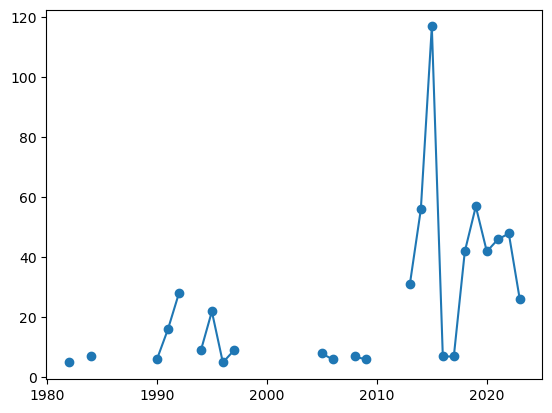

In [244]:
plt.plot(data['duration_max'], 'o-')

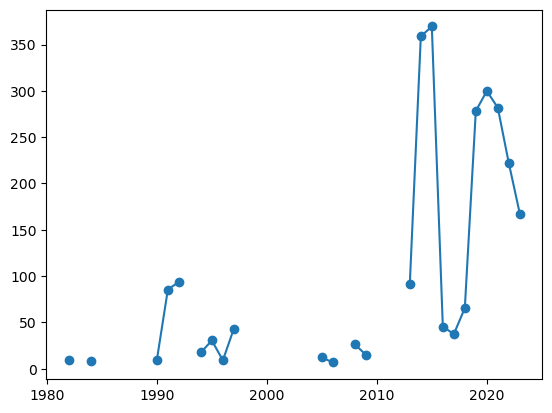

In [243]:
plt.plot(data['intensity_cum'], 'o-')

TypeError: float() argument must be a string or a real number, not 'method'

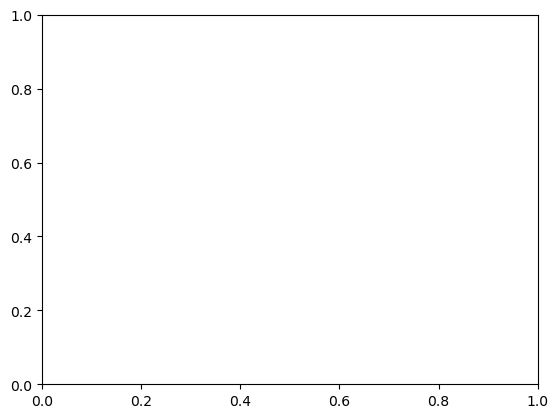

In [204]:
plt.plot(data.count)

In [151]:
yearlydf['count']=oneCell.groupby(oneCell.year).duration.max()

year
1982      5
1984      7
1990      6
1991     16
1992     28
1994      9
1995     22
1996      5
1997      9
2005      8
2006      6
2008      7
2009      6
2013     31
2014     56
2015    117
2016      7
2017      7
2018     42
2019     57
2020     42
2021     46
2022     48
2023     26
Name: duration, dtype: int64

In [ ]:
annual dataset: 
    dim (year, lat, lon)
    variables: 
        number of mhw
        max duration
        total duration
        intensity max
        intensity cum
        intensity mean
        
# LAter: expand to other indices

In [115]:
oneCell.groupby(oneCell.year).intensity_cumulative.sum()

year
1982      9.243094
1984      8.493570
1990      9.562619
1991     85.507141
1992     93.694038
1994     17.575714
1995     30.479998
1996      9.038570
1997     43.279045
2005     12.289523
2006      6.741669
2008     26.234285
2009     15.137145
2013     91.989761
2014    358.848328
2015    369.528320
2016     45.582382
2017     37.402382
2018     65.374527
2019    278.324524
2020    299.827850
2021    281.831909
2022    222.028809
2023    167.414276
Name: intensity_cumulative, dtype: float32

In [103]:
aa.head()

,lon,lat,duration,date_start,date_end,date_peak,index_start,index_end,index_peak,intensity_max,intensity_mean,intensity_var,intensity_cumulative,rate_onset,rate_decline,category,year
5,221.125,40.125,5,1982-06-19,1982-06-23,1982-06-20,169,173,170,2.184525,1.848619,0.280397,9.243094,NaN,NaN,NaN,1982
27,221.125,40.125,7,1984-10-24,1984-10-30,1984-10-26,1026,1032,1028,1.379286,1.213367,0.108708,8.493570,NaN,NaN,NaN,1984
126,221.125,40.125,6,1990-04-30,1990-05-05,1990-05-02,3039,3044,3041,1.785714,1.593770,0.190886,9.562619,NaN,NaN,NaN,1990
147,221.125,40.125,5,1991-01-22,1991-01-26,1991-01-25,3306,3310,3309,1.604048,1.431286,0.169224,7.156428,NaN,NaN,NaN,1991
203,221.125,40.125,7,1991-10-15,1991-10-21,1991-10-19,3572,3578,3576,1.376667,1.219592,0.115060,8.537144,NaN,NaN,NaN,1991
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2251,221.125,40.125,16,2023-05-22,2023-06-06,2023-05-28,15106,15121,15112,2.380715,1.959807,0.276386,31.356907,NaN,NaN,NaN,2023
2270,221.125,40.125,5,2023-06-15,2023-06-19,2023-06-15,15130,15134,15130,1.633096,1.604667,0.017760,8.023335,NaN,NaN,NaN,2023
2281,221.125,40.125,8,2023-06-29,2023-07-06,2023-07-02,15144,15151,15147,3.081903,2.502024,0.402839,20.016190,NaN,NaN,NaN,2023
2290,221.125,40.125,16,2023-07-13,2023-07-28,2023-07-18,15158,15173,15163,3.555239,2.591503,0.564765,41.464050,NaN,NaN,NaN,2023


In [ ]:
LATER: iterate over lat to get full GOA data. Or global data for Salil

In [55]:
nyears = 18

fin = f'/lcrc/group/e3sm/public_html/diagnostics/observations/Ocean/SST/daily/sst.day.mean.19[8-9]?.nc'
output_files = sorted(glob.glob(fin))
if len(output_files)!=nyears:
    print('oops, missing files')
    exit()


In [6]:
infiles

['/lcrc/group/e3sm/public_html/diagnostics/observations/Ocean/SST/daily/sst.day.mean.1982.nc',
 '/lcrc/group/e3sm/public_html/diagnostics/observations/Ocean/SST/daily/sst.day.mean.1983.nc',
 '/lcrc/group/e3sm/public_html/diagnostics/observations/Ocean/SST/daily/sst.day.mean.1984.nc',
 '/lcrc/group/e3sm/public_html/diagnostics/observations/Ocean/SST/daily/sst.day.mean.1985.nc',
 '/lcrc/group/e3sm/public_html/diagnostics/observations/Ocean/SST/daily/sst.day.mean.1986.nc',
 '/lcrc/group/e3sm/public_html/diagnostics/observations/Ocean/SST/daily/sst.day.mean.1987.nc',
 '/lcrc/group/e3sm/public_html/diagnostics/observations/Ocean/SST/daily/sst.day.mean.1988.nc',
 '/lcrc/group/e3sm/public_html/diagnostics/observations/Ocean/SST/daily/sst.day.mean.1989.nc',
 '/lcrc/group/e3sm/public_html/diagnostics/observations/Ocean/SST/daily/sst.day.mean.1990.nc',
 '/lcrc/group/e3sm/public_html/diagnostics/observations/Ocean/SST/daily/sst.day.mean.1991.nc',
 '/lcrc/group/e3sm/public_html/diagnostics/observa

In [73]:
# output_files

In [59]:
### Alternative loading approach with slice

# from functools import partial

# def _preprocess(x, lon_bnds, lat_bnds):
#     return x.sel(lon=slice(*lon_bnds), lat=slice(*lat_bnds))

# lon_bnds, lat_bnds = (220, 222), (40, 40.3)
# partial_func = partial(_preprocess, lon_bnds=lon_bnds, lat_bnds=lat_bnds)

# subds = xarray.open_mfdataset(fin, preprocess=partial_func)  

/lcrc/soft/climate/e3sm-unified/base/envs/e3sm_unified_1.10.0_login/lib/python3.10/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


In [103]:
np.where(latchunk)

(array([520]),)

In [95]:
ds = xarray.open_mfdataset(fin)

In [ ]:
# ds

In [9]:
subds = ds[:, latchunk, lonchunk]

In [68]:
fin = f'/lcrc/group/e3sm/public_html/diagnostics/observations/Ocean/SST/daily/sst.day.clim.1982-2023.nc'
dsclim = xarray.open_dataset(fin).sst
clim = np.tile(dsclim[:, latchunk, lonchunk], (nyears, 1, 1))

In [ ]:
'/lcrc/group/e3sm/ac.abarthel/scratch/mhw/hadSST/daily/sst.day.anom.{year}.clim1982-2023.nc'

In [49]:
# STEP 1: process the regional raw data

In [63]:
subds

<xarray.Dataset>
Dimensions:  (time: 6570, lat: 1, lon: 8)
Coordinates:
  * time     (time) datetime64[ns] 1982-01-01 1982-01-02 ... 1999-12-31
  * lat      (lat) float32 40.12
  * lon      (lon) float32 220.1 220.4 220.6 220.9 221.1 221.4 221.6 221.9
Data variables:
    sst      (time, lat, lon) float32 dask.array<chunksize=(365, 1, 8), meta=np.ndarray>
Attributes:
    Conventions:    CF-1.5
    title:          NOAA High-resolution Blended Analysis: Daily Values using...
    institution:    NOAA/NCDC
    source:         NOAA/NCDC  ftp://eclipse.ncdc.noaa.gov/pub/OI-daily-v2/
    history:        Thu Aug 24 13:35:47 2017: ncatted -O -a References,global...
    dataset_title:  NOAA Daily Optimum Interpolation Sea Surface Temperature
    References:     https://www.psl.noaa.gov/data/gridded/data.noaa.oisst.v2....
    comment:        Reynolds, et al.(2007) Daily High-Resolution-Blended Anal...

In [72]:
# likely, pass regional chunks (2D) to next steps
print('loading the regional chunk of data...')
start = time.time()
temp = subds.sst[:,0,:].values
end = time.time()
print(f'... took {end - start}s to load')
seas = clim[:,0,:]
anom = temp - seas
print(f'check: sst anomaly has shape, {np.shape(anom)}')

loading the regional chunk of data...
...took 92.49745988845825
check: sst anomaly has shape, (6570, 8)


In [ ]:
# probably faster to calculate the anomalies offline using nco (each year is sst - clim), or even xarray
# then produce th90 from either day by day 2D maps or using xarray.quantile(.90,dim=time) for each day
# OR you can produde the th90 per region like attempted here. 
# then if need be, you can load each year/ 10 year block and do the MHW analysis individually since you have th90, anom, temp, etc. 

In [69]:
print('calculating threshold')
th90 = [[np.nanpercentile(anom[n::365, loc], 90, axis = 0) for loc in np.arange(np.shape(anom)[1])] for n in np.arange(365)]
thre = np.tile(th90, (nyears,1))
print('detecting events above threshold')
# Potentially ADD smooth percentile here
mhw_bool = (subset[:,0,:] > clim[:,0,:] + thre[:,:])
# Find contiguous regions of exceed_bool = True
s2 = [[0,1,0],
      [0,1,0],
      [0,1,0]]
events, n_events = label(mhw_bool, structure = s2)
# sanity check regarding shape of event (lon contains all equal values)
check = all([len(subds.lon[np.where(events == ev)[1]].drop_duplicates(dim = 'lon'))==1 for ev in np.arange(1, n_events+1)] )
if ~check:
    'problem with the structure of events and/or lon'
print(f'{n_events} events were detected')
# probably save intermediate files here like temp, seas, th90 and (events, n_events)

calculating threshold
detecting events above threshold
1372 were detected


In [ ]:
# STEP 2: process the marine heat wave events

In [38]:
df

,lon,lat,duration,date_start,date_end,date_peak,index_start,index_end,index_peak,intensity_max,intensity_mean,intensity_var,intensity_cumulative,rate_onset,rate_decline,category
6,220.125,40.125,5,1982-06-19,1982-06-23,1982-06-20,169,173,170,1.901904,1.651142,0.217226,8.255713,NaN,NaN,NaN
7,220.375,40.125,5,1982-06-19,1982-06-23,1982-06-20,169,173,170,2.180953,1.930428,0.249735,9.652142,NaN,NaN,NaN
8,220.625,40.125,5,1982-06-19,1982-06-23,1982-06-20,169,173,170,2.339047,2.074000,0.299722,10.370000,NaN,NaN,NaN
9,220.875,40.125,5,1982-06-19,1982-06-23,1982-06-20,169,173,170,2.350239,2.051525,0.322943,10.257623,NaN,NaN,NaN
10,221.125,40.125,5,1982-06-19,1982-06-23,1982-06-20,169,173,170,2.184525,1.848619,0.280397,9.243094,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1333,220.875,40.125,6,1998-08-26,1998-08-31,1998-08-27,6077,6082,6078,1.715952,1.303214,0.212558,7.819286,NaN,NaN,NaN
1334,221.125,40.125,6,1998-08-26,1998-08-31,1998-08-27,6077,6082,6078,1.831429,1.324325,0.240723,7.945951,NaN,NaN,NaN
1335,221.375,40.125,6,1998-08-26,1998-08-31,1998-08-27,6077,6082,6078,1.879286,1.334008,0.250740,8.004049,NaN,NaN,NaN
1336,221.625,40.125,6,1998-08-26,1998-08-31,1998-08-27,6077,6082,6078,1.977856,1.414524,0.254648,8.487143,NaN,NaN,NaN


In [50]:
# probably save intermediate files here like regional df

In [ ]:
# add blocking per year
# add categories

In [92]:
start = df[(df.index_start <= 365)&(df.index_end >= 2*365)]

In [93]:
len(start.index)

0

In [ ]:
# add recombining regions

In [46]:
anom = temp - seas
np.shape(temp)

(6570, 8)

In [40]:
anom2 = subds[:,0,:] - seas
np.shape(anom2)

(6570, 8)

In [41]:
thre2 = [[np.nanpercentile(anom2[n::365, loc], 90, axis = 0) for loc in np.arange(8)] for n in np.arange(365)]

KeyboardInterrupt: 

In [10]:
subset = ds[:, latchunk, lonchunk].values

In [48]:
ds.lon[lonchunk][0]

<xarray.DataArray 'lon' ()>
array(220.125, dtype=float32)
Coordinates:
    lon      float32 220.1
Attributes:
    long_name:      Longitude
    standard_name:  longitude
    units:          degrees_east
    actual_range:   [1.25000e-01 3.59875e+02]
    axis:           X

In [ ]:
# probably redo with a DataArray rather than a dataframe!

In [ ]:
# building one event at a time for sanity check
ev = 1
df.loc[ev].duration = (events == ev).sum()
# could drop the short duration events here and save on calculations
df.loc[ev].lon = subds.lon[np.where(events == ev)[1]].drop_duplicates(dim = 'lon').values[0]
df.loc[ev].lat = subds.lat.values # For now Lat is 1 value from chunk mask. 
df.loc[ev].index_start = np.where(events == ev)[0][0]
df.loc[ev].index_end = np.where(events == ev)[0][-1]
df.loc[ev].date_start = subds.time[np.where(events == ev)[0][0]].values
df.loc[ev].date_end = subds.time[np.where(events == ev)[0][-1]].values
df.loc[ev].index_peak = df.loc[ev].index_start + np.argmax(mhw_relSeas[np.where(events == ev)])
df.loc[ev].date_peak = subds.time[df.loc[ev].index_peak].values
df.loc[ev].intensity_max = mhw_relSeas[df.loc[ev].index_peak].values
df.loc[ev].intensity_mean = mhw_relSeas[np.where(events == ev)].mean()
df.loc[ev].intensity_var = np.sqrt(mhw_relSeas[np.where(events == ev)].var())
df.loc[ev].intensity_cumulative = mhw_relSeas[np.where(events == ev)].sum()
# add other thresholds
df.loc[ev].intensity_max_relThresh = mhw_relThresh[df.loc[ev].index_peak].values
df.loc[ev].intensity_mean_relThresh = mhw_relThresh[np.where(events == ev)].mean()
df.loc[ev].intensity_var_relThresh = np.sqrt(mhw_relThresh[np.where(events == ev)].var())
df.loc[ev].intensity_cumulative_relThresh = mhw_relThresh[np.where(events == ev)].sum()
df.loc[ev].intensity_max_abs = temp[df.loc[ev].index_peak].values
df.loc[ev].intensity_mean_abs = temp[np.where(events == ev)].mean()
df.loc[ev].intensity_var_abs = np.sqrt(temp[np.where(events == ev)].var())
df.loc[ev].intensity_cumulative_abs = temp[np.where(events == ev)].sum()
# add categories
# add onset/decline rates

In [ ]:
ev = 1
df.loc[ev].lon = subds.lon[np.where(events == ev)[1]].drop_duplicates(dim = 'lon').values

In [ ]:
subds.lon[np.where(events == ev)[1]].drop_duplicates(dim = 'lon').values

In [ ]:
df.lat = np.tile(subds.lat.values, n_events) # For now Lat is 1 value from chunk mask. 

In [ ]:
dff = df.drop(df[df.duration < 5].index)

In [ ]:
dff

In [ ]:
df

In [ ]:
df.loc[ev].intensity_var = np.sqrt(mhw_relSeas[np.where(events == ev)].var())

In [ ]:
np.shape(mhw_relSeas)

In [ ]:
# tt_start = np.where(events == ev)[0][0]
# tt_end = np.where(events == ev)[0][-1]

# temp_mhw = temp[tt_start:tt_end+1]
# thresh_mhw = clim['thresh'][tt_start:tt_end+1]
# seas_mhw = clim['seas'][tt_start:tt_end+1]
mhw_relSeas = temp - seas
mhw_relThresh = temp - th90
mhw_relThreshNorm = (temp - th90) / (th90 - seas)
mhw_abs = temp
# Find peak
tt_peak = np.argmax(mhw_relSeas)


In [ ]:
np.shape(mhw_relSeas)

In [ ]:
mhw_relSeas[np.where(events == ev)]

In [ ]:
np.argmax(mhw_relSeas[np.where(events == ev)])

In [ ]:
df.loc[ev].index_peak = df.loc[ev].index_start + np.argmax(mhw_relSeas[np.where(events == ev)])

In [ ]:
# building full dimensions at a time
df.duration = [(events == ev).sum() for ev in np.arange(1, n_events+1)]

In [ ]:
np.where(events == ev)[0][-1]

In [ ]:
ev

In [ ]:
df.loc[1]

In [ ]:
np.where(events == ev)

In [ ]:
ds.lon[lonchunk][np.where(events == ev)[1]]

In [ ]:
ds.coords['time']

In [ ]:
ds.lon[lonchunk][np.where(events == ev)[1]].drop_duplicates(dim = 'lon').values

In [ ]:
ds.lon[np.where(events == ev)[0]]

In [ ]:
df.loc[ev]

In [ ]:
# thre = np.zeros(np.shape(dsclim[:, latchunk, lonchunk]))

In [ ]:
# for n in np.arange(365):
#     thre2 = [[np.nanpercentile(anom[n::365,0, loc], 90, axis = 0) for loc in np.arange(8)] for n in np.arange(365)]

In [ ]:
print(np.isnan(mhw_bool).any())
print(np.shape(mhw_bool))
print(np.shape(events))

In [ ]:
from scipy.ndimage import label

In [ ]:
np.shape(mhw_bool)

In [ ]:
np.shape(events)

In [ ]:
events

In [ ]:
mhw_duration = np.zeros(np.shape(events))

In [ ]:
minDuration = 5
# Find all MHW events of duration >= minDuration
for ev in range(1,n_events+1):
    event_duration = (events == ev).sum()
    if event_duration < minDuration:
        mhw_duration[np.where(events == ev)] = 0
    else: 
        mhw_duration[np.where(events == ev)] = event_duration
        mhw['time_start'].append(t[np.where(events == ev)[0][0]])
        mhw['time_end'].append(t[np.where(events == ev)[0][-1]])

In [ ]:
# drop the ones with too small (or zero) duration

In [ ]:
n_events

In [ ]:
np.shape(anom[n::365,:, :])

In [ ]:
np.shape(t)

In [ ]:
def generate_clim():
    
    clim = np.tile(dsclim[:, latchunk, lonchunk], (10,1, 1))
    anom = subset - clim
    thre = np.nanpercentile(anom, 90, axis = 0)
    
    

In [ ]:
clim = np.zeros(np.shape(subset))


In [ ]:
subset

In [ ]:
np.arange(0, len(ds.time), 365)

In [ ]:
for n in np.arange(0, len(ds.time), 365):
    clim[n:(n+365), :, :] = dsclim[:, latchunk, lonchunk]

In [ ]:
clim2 = np.tile(dsclim[:, latchunk, lonchunk], (10,1, 1))

In [ ]:
np.shape(clim2)

In [ ]:
plt.plot(clim2[:, 0, 0])
plt.plot(clim2[:, 0, 0]+ th90[:,0])
plt.plot(subset[:,0,0])

In [ ]:
np.shape(clim)

In [ ]:
plt.plot(clim[:, 0, 0])

In [ ]:
fin = f'/lcrc/group/e3sm/public_html/diagnostics/observations/Ocean/SST/daily/sst.day.clim.1982-2023.nc'
dsclim = xarray.open_dataset(fin).sst

In [ ]:
def generate_thresholds():
    

In [ ]:
ds[:, latchunk, lonchunk

In [ ]:
np.shape(subset)

In [ ]:
global_clim = np.zeros(np.shape(ds))
global_thre = np.zeros(np.shape(ds))
ii = 0
global_mhws = {}
sst = xarray.open_mfdataset(fin).sst

In [ ]:
ii = 0
for xx in np.arange(len(ds.lat)):
    for yy in np.arange(len(ds.lon)):
        print(ii)
        mhws, clim = mhw.detect(t, sst[:, xx, yy].values)
        global_clim[:, xx, yy] = clim['seas'][:]
        global_thre[:, xx, yy] = clim['thresh'][:]
        global_mhws[ii] = {'lat': ds.lat[xx].values, 'lon': ds.lon[yy].values, 'mhw': mhw}
        ii = ii+1

In [ ]:
with open('../daily_MHW_HadSST/global_mhw.npy', 'wb') as f:
    np.save(f, global_mhws)

with open('../daily_MHW_HadSST/globalclim.npy', 'wb') as f:
    np.save(f, [global_clim, global_thre])

In [ ]:
# edit for next: 
mhwBlock = mhw.blockAverage(t, mhws)
mean, trend, dtrend = mhw.meanTrend(mhwBlock)

In [ ]:
locations = [500, 1500, 414181, 354504]
locc = locations[-1]

In [ ]:
llon = np.where(np.logical_and(ds.lon > 220.5, ds.lon <= 220.75))[0]
llat = np.where(np.logical_and(ds.lat > 47, ds.lat <= 47.35))[0]

In [ ]:
llat[0]

In [ ]:
sst.values[0]

## Marine Heatwave Detection

The marineHeatWaves (`mhw`) module consists of a number of functions for the detection and characterization of MHWs. The main function is the detection function (`detect`) which takes as input a time series of temperature (and a corresponding time vector) and outputs a set of detected MHWs. We first run the MHW detection algorithm which returns the variable `mhws`, consisting of the detected MHWs, and `clim`, consisting of the climatological (varying by day-of-year) seasonal cycle and extremes threshold:


In [ ]:
mhws, clim = mhw.detect(t, sst.values)

In [ ]:
mhws

In [ ]:
global_clim[:, llat[0], llon[0]] = clim['seas'][:]
global_thre[:, llat[0], llon[0]] = clim['thresh'][:]

In [ ]:
global_mhws[ii] = {'lat': lat[llat[0]], 'lon': lon[llon[0]], 'mhw': mhw}
ii =+1

In [ ]:
clim['lat'] = ds.lat[llat[0]].values
clim['lon'] = ds.lon[llon[0]].values

In [ ]:
clim['seas'][:]

In [ ]:
clim

This algorithm has detected the following number of MHW events:

In [ ]:
mhws['n_events']

The first ten events, for example, have the following maximum intensities (in $^\circ$C):

In [ ]:
mhws['intensity_max'][0:10]

Let's have a look at some properties of the event with the largest maximum intensity

In [ ]:
ev = np.argmax(mhws['intensity_max']) # Find largest event
print ('Maximum intensity:', mhws['intensity_max'][ev], 'deg. C')
print ('Average intensity:', mhws['intensity_mean'][ev], 'deg. C')
print ('Cumulative intensity:', mhws['intensity_cumulative'][ev], 'deg. C-days')
print ('Duration:', mhws['duration'][ev], 'days')
print ('Start date:', mhws['date_start'][ev].strftime("%d %B %Y"))
print ('End date:', mhws['date_end'][ev].strftime("%d %B %Y"))

In [ ]:
ev

In [ ]:
with open('../daily_MHW_HadSST/mhw.npy', 'wb') as f:
    np.save(f, mhws)

with open('../daily_MHW_HadSST/clim.npy', 'wb') as f:
    np.save(f, clim)

In [ ]:
var = sst.values

In [ ]:
np.shape(sst)

In [ ]:
plt.plot(dates, var, 'k-')
plt.plot(dates, clim['thresh'], 'g-')
plt.plot(dates, clim['seas'], 'b-')

and a closer look at the identified MHW event:

In [ ]:
plt.figure(figsize=(14,10))
ax = plt.subplot(2,1,1)
# Plot SST, seasonal cycle, and threshold
ax.plot(dates, var, 'k-')
ax.plot(dates, clim['thresh'], 'g-')
ax.plot(dates, clim['seas'], 'b-')
plt.title('SST (black), seasonal climatology (blue), \
          threshold (green), detected MHW events (shading)')
ax.set_xlim(dates[0], dates[-1])
ax.set_ylim(var.min()-0.5, var.max()+0.5)
ax.set_ylabel(r'SST [$^\circ$C]')

In [ ]:
plt.figure(figsize=(14,10))
plt.subplot(2,1,1)
# Plot SST, seasonal cycle, and threshold
plt.plot(dates, sst, 'k-')
plt.plot(dates, clim['thresh'], 'g-')
plt.plot(dates, clim['seas'], 'b-')
plt.title('SST (black), seasonal climatology (blue), \
          threshold (green), detected MHW events (shading)')
plt.xlim(dates[0], dates[-1])
plt.ylim(sst.min()-0.5, sst.max()+0.5)
plt.ylabel(r'SST [$^\circ$C]')
plt.subplot(2,1,2)
# Find indices for all ten MHWs before and after event of interest and shade accordingly
for ev0 in np.arange(ev-10, ev+11, 1):
    t1 = np.where(t==mhws['time_start'][ev0])[0][0]
    t2 = np.where(t==mhws['time_end'][ev0])[0][0]
    plt.fill_between(dates[t1:t2+1], sst[t1:t2+1], clim['thresh'][t1:t2+1], \
                     color=(1,0.6,0.5))
# Find indices for MHW of interest and shade accordingly
t1 = np.where(t==mhws['time_start'][ev])[0][0]
t2 = np.where(t==mhws['time_end'][ev])[0][0]
plt.fill_between(dates[t1:t2+1], sst[t1:t2+1], clim['thresh'][t1:t2+1], \
                 color='r')
# Plot SST, seasonal cycle, threshold, shade MHWs with main event in red
plt.plot(dates, sst, 'k-', linewidth=2)
plt.plot(dates, clim['thresh'], 'g-', linewidth=2)
plt.plot(dates, clim['seas'], 'b-', linewidth=2)
plt.title('SST (black), seasonal climatology (blue), \
          threshold (green), detected MHW events (shading)')
plt.xlim(mhws['time_start'][ev]-150, mhws['time_end'][ev]+150)
plt.ylim(clim['seas'].min() - 1, clim['seas'].max() + mhws['intensity_max'][ev] + 0.5)
plt.ylabel(r'SST [$^\circ$C]')

In [ ]:
dates[0]

In [ ]:
plt.subplot(2,1,2)
# Find indices for all ten MHWs before and after event of interest and shade accordingly
for ev0 in np.arange(ev-10, ev+11, 1):
    t1 = np.where(t==mhws['time_start'][ev0])[0][0]
    t2 = np.where(t==mhws['time_end'][ev0])[0][0]
    plt.fill_between(dates[t1:t2+1], var[t1:t2+1], clim['thresh'][t1:t2+1], \
                     color=(1,0.6,0.5))
# Find indices for MHW of interest and shade accordingly
t1 = np.where(t==mhws['time_start'][ev])[0][0]
t2 = np.where(t==mhws['time_end'][ev])[0][0]
plt.fill_between(dates[t1:t2+1], var[t1:t2+1], clim['thresh'][t1:t2+1], \
                 color='r')
# Plot SST, seasonal cycle, threshold, shade MHWs with main event in red
plt.plot(dates, var, 'k-', linewidth=2)
plt.plot(dates, clim['thresh'], 'g-', linewidth=2)
plt.plot(dates, clim['seas'], 'b-', linewidth=2)
plt.title('SST (black), seasonal climatology (blue), \
          threshold (green), detected MHW events (shading)')
plt.xlim(mhws['time_start'][ev]-150, mhws['time_end'][ev]+150)
plt.ylim(clim['seas'].min() - 1, clim['seas'].max() + mhws['intensity_max'][ev] + 0.5)
plt.ylabel(r'SST [$^\circ$C]')

Yep, It's certainly picked out the largest event in the series (dark red shading). This event also seems to have been preceded and succeeded by a number of shorter, weaker events (light red shading). Let's have a look at how the MHW statistics are distributed across all the detected events:

In [ ]:
plt.figure(figsize=(15,7))
# Duration
plt.subplot(2,2,1)
evMax = np.argmax(mhws['duration'])
plt.bar(range(mhws['n_events']), mhws['duration'], width=0.6, \
        color=(0.7,0.7,0.7))
plt.bar(evMax, mhws['duration'][evMax], width=0.6, color=(1,0.5,0.5))
plt.bar(ev, mhws['duration'][ev], width=0.6, edgecolor=(1,0.,0.), \
        color='none')
plt.xlim(0, mhws['n_events'])
plt.ylabel('[days]')
plt.title('Duration')
# Maximum intensity
plt.subplot(2,2,2)
evMax = np.argmax(mhws['intensity_max'])
plt.bar(range(mhws['n_events']), mhws['intensity_max'], width=0.6, \
        color=(0.7,0.7,0.7))
plt.bar(evMax, mhws['intensity_max'][evMax], width=0.6, color=(1,0.5,0.5))
plt.bar(ev, mhws['intensity_max'][ev], width=0.6, edgecolor=(1,0.,0.), \
        color='none')
plt.xlim(0, mhws['n_events'])
plt.ylabel(r'[$^\circ$C]')
plt.title('Maximum Intensity')
# Mean intensity
plt.subplot(2,2,4)
evMax = np.argmax(mhws['intensity_mean'])
plt.bar(range(mhws['n_events']), mhws['intensity_mean'], width=0.6, \
        color=(0.7,0.7,0.7))
plt.bar(evMax, mhws['intensity_mean'][evMax], width=0.6, color=(1,0.5,0.5))
plt.bar(ev, mhws['intensity_mean'][ev], width=0.6, edgecolor=(1,0.,0.), \
        color='none')
plt.xlim(0, mhws['n_events'])
plt.title('Mean Intensity')
plt.ylabel(r'[$^\circ$C]')
plt.xlabel('MHW event number')
# Cumulative intensity
plt.subplot(2,2,3)
evMax = np.argmax(mhws['intensity_cumulative'])
plt.bar(range(mhws['n_events']), mhws['intensity_cumulative'], width=0.6, \
        color=(0.7,0.7,0.7))
plt.bar(evMax, mhws['intensity_cumulative'][evMax], width=0.6, color=(1,0.5,0.5))
plt.bar(ev, mhws['intensity_cumulative'][ev], width=0.6, edgecolor=(1,0.,0.), \
        color='none')
plt.xlim(0, mhws['n_events'])
plt.title(r'Cumulative Intensity')
plt.ylabel(r'[$^\circ$C$\times$days]')
plt.xlabel('MHW event number')

The red shaded bars show the largest event on record by duration, maximum intensity, cumulative intensity, and mean intensity, while the red-outlined bars show the specific event chosen above (which happens to be largest by maximum intensity). We can see how this event ranks according to the other metrics as follows:

In [ ]:
rank, returnPeriod = mhw.rank(t, mhws)
print("The 2012 NWA event is ranked number " \
        + str(rank['duration'][ev]) + " by duration")
print ("The 2012 NWA event is ranked number " \
        + str(rank['intensity_max'][ev]) + " by maximum intensity")
print ("The 2012 NWA event is ranked number " \
        + str(rank['intensity_mean'][ev]) + " by mean intensity")
print ("The 2012 NWA event is ranked number " \
        + str(rank['intensity_cumulative'][ev]) + " by cumulative intensity")

We can even look at the return periods for events with those properties:

In [ ]:
print ("The return period for an event with this duration was " \
        + str(returnPeriod['duration'][ev]) + " years")
print ("The return period for an event with this maximum intensity was " \
        + str(returnPeriod['intensity_max'][ev]) + " years")
print ("The return period for an event with this mean intensity was " \
        + str(returnPeriod['intensity_mean'][ev]) + " years")
print ("The return period for an event with this cumulative intensity was " \
        + str(returnPeriod['intensity_cumulative'][ev]) + " years")

## Block-averaged Marine Heatwave properties

The marineHeatWaves (`mhw`) module also consists of functions to calculate the average of MHW properties over blocks in time (e.g., annually, decadally). The block-averaging function (`blockAverage`) takes as input a set of detected MHWs (i.e., the output from `detect`, the detection function described above) and outputs the MHW properties averaged over the specified block-length. This output can then be passed through the `meanTrend` function in order to calculate the time-mean and linear trend of the MHW properties over the measurement period.

Let's start by applying the block-averaging function to the Mediterranean MHWs which are stored in the variable `mhws`, using the default block length of 1 year (i.e., annual averages):

In [ ]:
mhwBlock = mhw.blockAverage(t, mhws)

In [ ]:
mhwBlock

The variable `mhwBlock` has a set of keys which are time series of the MHW properties over the blocks. The central year of the blocks are stored in the key `years_centre` so we can look at, as an example, time series of MHW counts in each year and the average maximum intensity in each year:


In [ ]:
plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
plt.plot(mhwBlock['years_centre'], mhwBlock['count'], 'k-o')
plt.ylim(0,9)
plt.ylabel('[count]')
plt.title('Number of MHWs by year')
plt.subplot(1,2,2)
plt.plot(mhwBlock['years_centre'], mhwBlock['intensity_max'], 'k-o')
plt.ylabel(r'[$^\circ$C]')
plt.title('Average MHW maximum intensity by year')

In [ ]:
mhwBlock.keys()

In [ ]:
plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
plt.plot(mhwBlock['years_centre'], mhwBlock['total_days'], 'k-o')
plt.ylim(0,250)
plt.xlim([1980, 2024])
plt.ylabel('[days]')
plt.title('Total days of MHWs by year')
plt.subplot(1,2,2)
plt.plot(mhwBlock['years_centre'], mhwBlock['intensity_cumulative'], 'k-o')
plt.xlim([1980, 2024])
plt.ylabel(r'[$^\circ$C]')
plt.title('cumulative MHW maximum intensity by year')

We can calculate the mean and trend of the MHW properties using the `meanTrend` function:

In [ ]:
mean, trend, dtrend = mhw.meanTrend(mhwBlock)
print ("There are on average " + str(mean['count']) + " MHWs in each year, \n \
with a linear trend of " + str(10*trend['count']) + " MHW events per decade \n \
This trend is statistically significant (p<0.05): " \
+ str(np.abs(trend['count']) > dtrend['count']) + "\n")

print ("The average maximum intensity is " + str(mean['intensity_max']) + " deg. C, \n \
with a linear trend of " + str(10*trend['intensity_max']) + " deg. C per decade \n \
This trend is statistically significant (p<0.05): " \
+ str(np.abs(trend['intensity_max']) > dtrend['intensity_max']))